# Restricted Boltzmann Machine - MNIST

## MEMBERS
- Sebastian Waruszynski 2157558
- Miguel Avilés 2141675
- Pietro Biliato 2009866
- Josè Gonzalez Lopez de Lerma 2121944

## Imports

In [1]:
import sys, datetime

# numpy
import numpy as np
from numpy import exp,sqrt,log,log10,sign,power,cosh,sinh,tanh,floor
rng = np.random.default_rng(12345)
np.set_printoptions(precision=4)

# matplotlib
import matplotlib as mpl
%matplotlib inline
from matplotlib.ticker import NullFormatter, MaxNLocator
mpl.rcParams.update({"font.size": 12})  #"text.usetex": True,})
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# to load MNIST
from sklearn.datasets import fetch_openml

!mkdir FIG 
!mkdir FIG/FRAME
!mkdir WEIGHTS 
!mkdir DATA

Sottodirectory o file FIG gi� esistente.
Sintassi del comando errata.
Sottodirectory o file WEIGHTS gi� esistente.
Sottodirectory o file DATA gi� esistente.


## Load data

In [2]:
X_original, Y_original = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
print(X_original.shape)

(70000, 784)


## Parameters

In [3]:
################################
#    CHOICE OF PARAMETERS      #
################################
# number of MNIST digits to keep (e.g., Ndigit=3 keeps 0,1,2)
Ndigit=3
# number of hidden units
L = 3
# use (+1,-1) if SPINS, otherwise use bits (1,0)
SPINS=True
# use one-hot encoding in hidden space if POTTS (use only if SPINS=False)
POTTS=False

dname='DATA/'
################################

# x_min =0 if bits, x_min=-1 if SPINS
# level_gap is the difference in values between the max (1) and the min (x_min)
if SPINS:
    x_min=-1
    level_gap=2.
else:
    x_min=0
    level_gap=1.

if POTTS:
    str_simul="RBM_Potts"
    # in one-hot encoding, number of possible hidden states matches L
    Nz=L
else:
    str_simul="RBM"
    # number of possible hidden states: 2**L
    Nz=2**L
    
if POTTS and SPINS: 
    print("\n\n>>>>>>>> WARNING:  POTTS and SPINS cannot coexist\n\n")

## Select data, and digitalize them two levels

('0', '1', '2')
dataset with 21770 points, each with 784 bits

first 10 MNIST data points


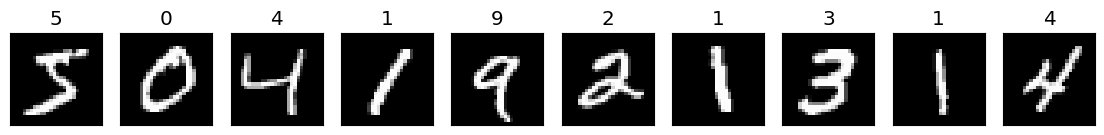

first 10 MNIST-3 data points


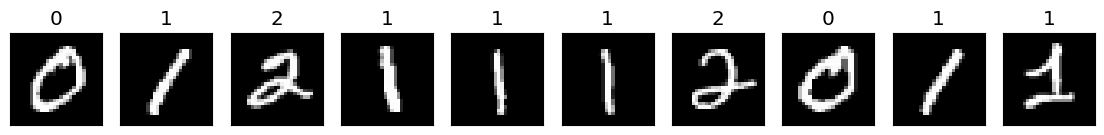

first 10 MNIST-3 data points, binarized


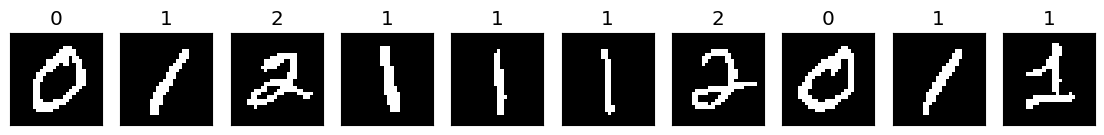

each of Nd=21770 data has D=784 bits


In [4]:
def show_MNIST(x, y=[], z=[], Nex=5, S=1.4, side=0, colors=[]):
    """Show digits"""
    if side==0: side = int(sqrt(x.shape[1]))
    if len(y)<1: y=np.full(Nex,"")
    colors=np.array(colors)
    fig, AX = plt.subplots(1,Nex,figsize=(S*Nex,S))
    
    for i, img in enumerate(x[:Nex].reshape(Nex, side, side)):
        if len(colors)==0: newcmp = "gray"
        else:
            col= colors[0] + (colors[1]-colors[0])*(i+1)/(Nex+1)
            newcmp = ListedColormap((col,(1,1,1,1)))
        ax=AX[i]
        ax.imshow(img, cmap=newcmp)
        ax.set_xticks([])
        ax.set_yticks([])
        if len(y)>0: ax.set_title(y[i])
        if len(z)>0: ax.set_title(''.join(map(str, z[i])),fontsize=9)
    plt.show()
            
def MNIST_bit(X,side=28,level=0.5):
    NX=len(X)
    #print(X.shape)
    print(f"dataset with {NX} points, each with {len(X[0])} bits\n")
    if side==14:
        X = np.reshape(X,(NX,28,28))
        # new value = average over 4 values in a 2x2 square
        Xr = 0.25*(X[:,0::2,0::2]+X[:,1::2,0::2]+X[:,0::2,1::2]+X[:,1::2,1::2])
        X  = Xr.reshape(NX,side**2)
    #print(X.shape)
    # binarize data and then convert it to 1/0 or 1/-1
    X = np.where(X/255 > level, 1, x_min)
    return X.astype("int")

list_10_digits = ('0','1','2','3','4','5','6','7','8','9')
list_digits = list_10_digits[:Ndigit]
print(list_digits)
keep=np.isin(Y_original, list_digits)
X_keep,Y=X_original[keep],Y_original[keep]

data,label = MNIST_bit(X_keep),Y
data,label = data.astype("int"),label.astype("int")
print("first 10 MNIST data points")
show_MNIST(X_original, Y_original,Nex=10)
print(f"first 10 MNIST-{Ndigit} data points")
show_MNIST(X_keep, label,Nex=10)
print(f"first 10 MNIST-{Ndigit} data points, binarized")
show_MNIST(data, label,Nex=10)

# number of data points
Nd = len(data)
# number of visible units
D  = len(data[1])

print(f'each of Nd={Nd} data has D={D} bits')

## Plotting data stats

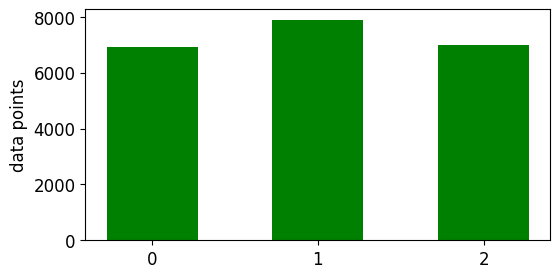

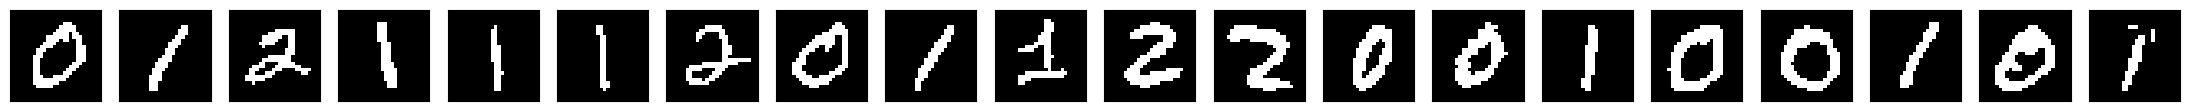

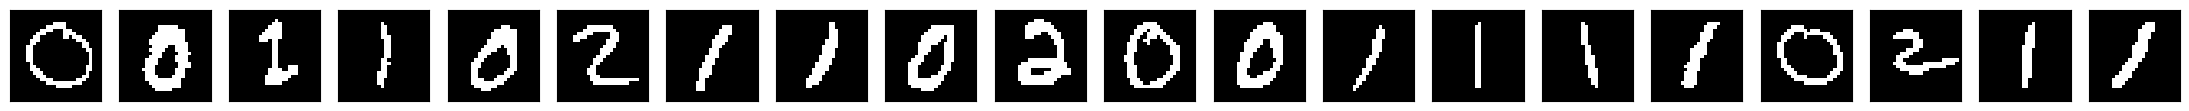

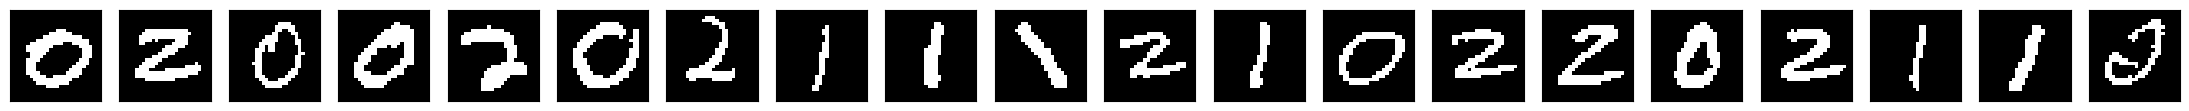

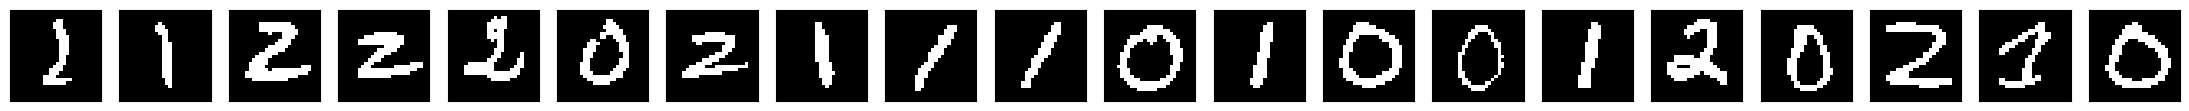

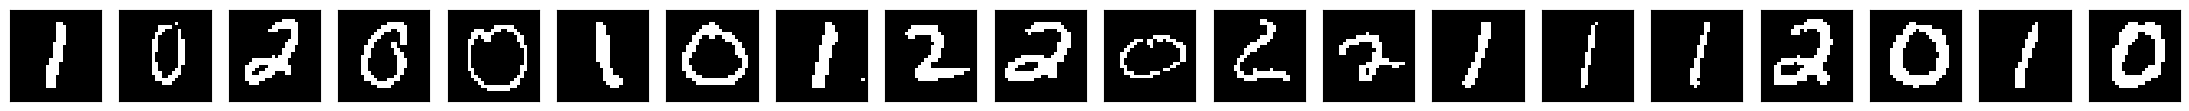

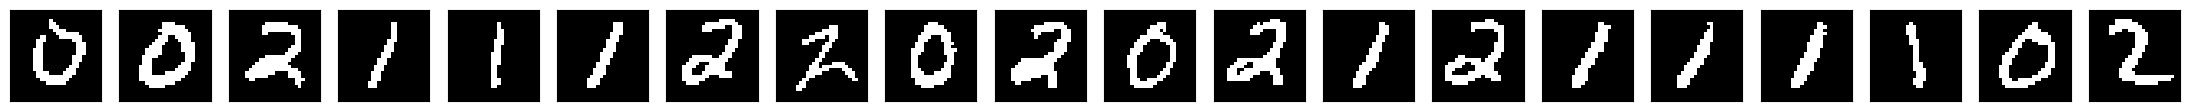

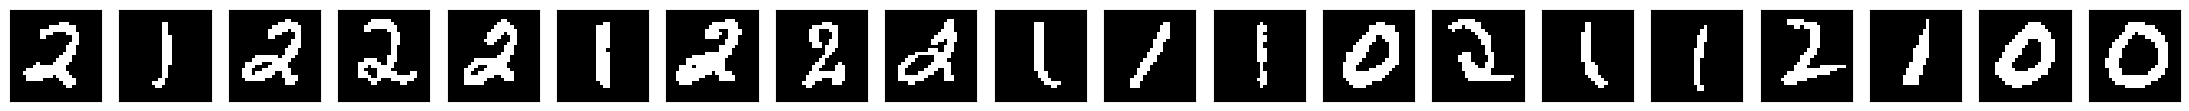

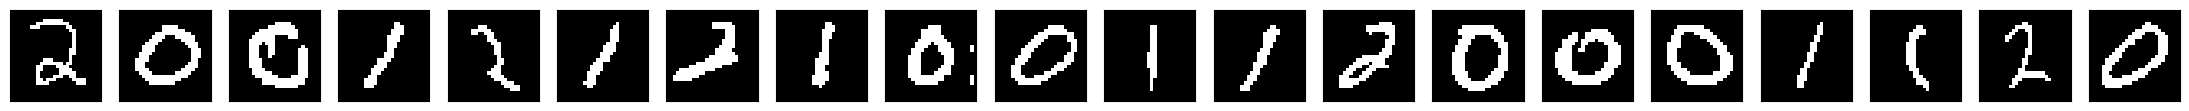

In [5]:
fig, (ax) = plt.subplots(1,1,figsize=(6,3))
ax.hist(np.sort(label),bins=np.arange(Ndigit+1)-1/2,density=False,rwidth=0.55,color="g")
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.set_ylabel("data points")
plt.show()
for i in range(8): show_MNIST(data[i*20:],Nex=20)

## Contrastive divergence (CD)


In [6]:
# eq(213) page 97, activation via sigmoid
# taking into account energy gap 2 for "spin" variables (-1,1)
def CD_step(v_in,wei,bias,details=False,POTTS=False):
    """
        Generates the state on the other layer: 
        Field "H" ->  activation "a" -> probability "p" -> Spins/bits v_out

        Either (v_in=x, wei=w) or (v_in=z, wei=w.T)

        details = True --> returns also probability (p) and activation (a) 

        POTTS means one-hot encoding (used only in hidden space)
    """
    # local "field"
    H = np.clip(np.dot(v_in, wei) + bias, a_min=-300, a_max=300)
    # "activation"
    a = exp(level_gap*H)
    n = np.shape(H)
    v_out = np.full(n, x_min, dtype=int) # initially, just a list on -1's or 0's
    if POTTS: # RBM with a single hidden unit = 1 (that is, "one-hot encoding" with L states)
        # p: state probability, normalized to 1 over all units=states
        p = a/np.sum(a)
        # F: cumulative probability
        F = np.cumsum(p)
        # pick a state "i" randomly with probability p[i]
        r = np.random.rand()
        i = 0
        while r>F[i]: i+=1
        v_out[i] = 1 # activate a single hidden unit
    else: # normal Ising RBM
        # p: local probability, normalized to 1 for each hidden unit
        p = a / (a + 1.)
        # at each position i, activate the 1's with local probability p[i]
        v_out[np.random.random_sample(n) < p] = 1 

    if details: return v_out,p,a
    else: return v_out

## Plot weights

In [7]:
def plot_weights_bias(wE, bE, epoch, L, 
                      side=0,cols=0,thr=0,s=1.5, 
                      title=False, save=True,cmap="bwr"):
    '''
    Plot the weights of the RBM, one plot for each hidden unit.
    '''
    rows = int(np.ceil(L / cols))
    if rows==1: rows=2
    w=wE[epoch]
    b=bE[epoch]
    if side==0: side=int(sqrt(len(w)))
    if thr==0: thr=4
    plt.clf()
    fig, AX = plt.subplots(rows, cols+1, figsize=(s*(1+cols),s*rows))
    if title: fig.suptitle(f"epoch = {epoch}")
    k=1
    for i in range(rows):
        for j in range(cols):
            if rows==1: ax=AX[j+1]
            else: ax=AX[i,j+1]
            if k<=L:
                ax.imshow(w[:,k-1].reshape(side, side), cmap=cmap,vmin=-thr,vmax=thr)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_title(f"hidden {k}")
            else: fig.delaxes(ax)
            k+=1
        if i>0:  fig.delaxes(AX[i,0])
    
    ax=AX[0,0];
    im=ax.imshow(b.reshape(side, side), cmap=cmap,vmin=-thr,vmax=thr)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("bias")
    # colobar
    cbar_ax = fig.add_axes([0.14, 0.15, 0.024, 0.33])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=12)
    
    S=0.3
    plt.subplots_adjust(hspace=S)

    if save: plt.savefig(f"./FIG/FRAME/RBM_{epoch}_w-a.png")

    plt.show()
    plt.close()


## Weights initialization 

In [8]:
# initial bias of visible units, based on their average value in the dataset
# Hinton, "A Practical Guide to Training Restricted Boltzmann Machines"
def Hinton_bias_init(x):
    xmean=np.array(np.mean(x,axis=0))
    # remove values at extrema, to avoid divergences in the log's
    S = 1e-4
    x1,x2 = x_min+S,1-S
    xmean[xmean<x1] = x1
    xmean[xmean>x2] = x2
    return (1/level_gap)*np.clip(log(xmean-x_min) - log(1-xmean),-300,300)
    
# range of each initial weight
# Glorot and Bengio, "Understanding the difficulty of training deep feedforward neural networks"
sigma = sqrt(4. / float(L + D))

## This initialization is imporant in order to obtain a good learning algorithm with RBMs, below we show the gradients with a Hinton (w,b,a) and random (w',a',b') initialization




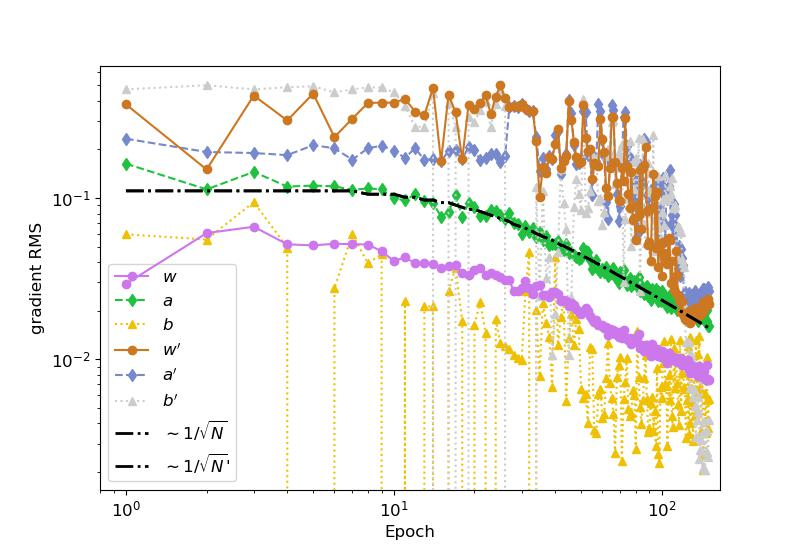

In [45]:
from IPython.display import display, HTML
import base64

def embed_image(image_path):
    with open(image_path, "rb") as f:
        encoded = base64.b64encode(f.read()).decode('utf-8')
    # Assuming the image is in JPEG format
    return f"data:image/jpeg;base64,{encoded}"

html = """
<div style="display: flex">
  <img src="{img}" alt="Image 1" width="35%" />
</div>
""".format(img=embed_image("jose.jpg"))

display(HTML(html))


## Gradient descent method

In [ ]:
# Gradient descent options
GRAD_list=["SGD","RMSprop"]
GRAD=GRAD_list[0]
if GRAD=="SGD":
    l_rate_ini,l_rate_fin=1.0,0.25
if GRAD=="RMSprop":
    beta,epsilon=0.9,1e-4
    l_rate_ini,l_rate_fin=0.05,0.05
    print("epsilon=",epsilon)
gamma = 0.001 ######### for regularization

print(f"D={D}\tsample size\nL={L}\tnr. z states")
print("Gradient descent type:",GRAD)
print(f"learning rate        = {l_rate_ini} --> {l_rate_fin}")
if gamma!=0: print(f"gamma={gamma}\tregularization")

D=784	sample size
L=3	nr. z states
Gradient descent type: SGD
learning rate        = 1.0 --> 0.25
gamma=0.001	regularization


# RBM train


In [ ]:
N_ini,N_fin=10,500
def RBM_train(steps, Nepoch, Nmini, plot, info, L, GRAD, gamma):
    # random seed for reproducibility
    np.random.seed(12345)
    
    # initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
    w = sigma * np.random.randn(D,L)
    a = Hinton_bias_init(data)
    b = np.zeros(L)
    
    if GRAD == "SGD":
        l_rate_ini, l_rate_fin = 1.0, 0.25
    elif GRAD == "RMSprop":
        beta, epsilon = 0.9, 1e-4
        l_rate_ini, l_rate_fin = 0.05, 0.05
        #print("epsilon=", epsilon)
    
    '''print(f"D={D}\tsample size\nL={L}\tnr. z states")
    print("Gradient descent type:", GRAD)
    print(f"learning rate        = {l_rate_ini} --> {l_rate_fin}")
    if gamma != 0: print(f"gamma={gamma}\tregularization")'''
    
    #print(f"Nepoch={Nepoch}\nNmini={Nmini}")
    Nt = steps
    
    wE, aE, bE = np.zeros((Nepoch+1, D, L)), np.zeros((Nepoch+1, D)), np.zeros((Nepoch+1, L))
    wE[0], aE[0], bE[0] = np.copy(w), np.copy(a), np.copy(b)
    gwE, gw2E, gwE_d, gwE_m = np.zeros_like(wE), np.zeros_like(wE), np.zeros_like(wE), np.zeros_like(wE)
    gaE, ga2E, gaE_d, gaE_m = np.zeros_like(aE), np.zeros_like(aE), np.zeros_like(aE), np.zeros_like(aE)
    gbE, gb2E, gbE_d, gbE_m = np.zeros_like(bE), np.zeros_like(bE), np.zeros_like(bE), np.zeros_like(bE)
    miniE = np.zeros(Nepoch+1)
    pzE = np.zeros((Nepoch+1, Nz))
    if GRAD == "RMSprop":
        gw2, ga2, gb2 = np.zeros_like(w), np.zeros_like(a), np.zeros_like(b)
    
    indices = np.arange(Nd).astype("int")
    #plot_weights_bias(wE, aE, 0, L, cols=L//2, save=False)
    
    Ncols = min(8, max(2, L//2))
    
    print("Starting the training")
    
    for epoch in range(1, 1 + Nepoch):
        q = (epoch-1.) / (Nepoch-1.)
        N = int(10 + (500-10) * (q**2))
        l_rate = l_rate_ini + (l_rate_fin - l_rate_ini) * q
    
        for mini in range(Nmini):
            x_data, x_model = np.zeros(D), np.zeros(D)
            z_data, z_model = np.zeros(L), np.zeros(L)
            xz_data, xz_model = np.zeros((D,L)), np.zeros((D,L))
            pz = np.zeros(L)
            
            selected = np.random.choice(indices, N, replace=False)
            for k in range(N):
                x0 = data[selected[k]]
                z = CD_step(x0, w, b)
                x_data += x0
                z_data += z
                xz_data += np.outer(x0, z)
                
                zf = np.copy(z)
                for t in range(Nt):
                    xf = CD_step(zf, w.T, a)
                    zf = CD_step(xf, w, b)
                x_model += xf
                z_model += zf
                xz_model += np.outer(xf, zf)
            
            gw_d, gw_m = xz_data/N, xz_model/N
            ga_d, ga_m = x_data/N, x_model/N
            gb_d, gb_m = z_data/N, z_model/N
            gw, ga, gb = np.copy(gw_d - gw_m), np.copy(ga_d - ga_m), np.copy(gb_d - gb_m)
    
            if GRAD == "RMSprop":
                gw2 = beta * gw2 + (1 - beta) * np.square(gw)
                ga2 = beta * ga2 + (1 - beta) * np.square(ga)
                gb2 = beta * gb2 + (1 - beta) * np.square(gb)
                w += l_rate * gw / np.sqrt(epsilon + gw2)
                a += l_rate * ga / np.sqrt(epsilon + ga2)
                b += l_rate * gb / np.sqrt(epsilon + gb2)
            else:
                w += l_rate * gw
                a += l_rate * ga
                b += l_rate * gb
            
            if gamma > 0.:
                w -= (gamma * l_rate) * np.sign(w)
                a -= (gamma * l_rate) * np.sign(a)
                b -= (gamma * l_rate) * np.sign(b)
    
        wE[epoch], aE[epoch], bE[epoch] = np.copy(w), np.copy(a), np.copy(b)
        if info:
            print("epoch",epoch,"/",Nepoch," Nt:",Nt," N:",N," L:",L," rate:",l_rate," gam:",gamma,"SPINS=",SPINS,"POTTS=",POTTS)
        if plot:
            if Nepoch<=100 or epoch%20==0 or epoch==Nepoch:
                plot_weights_bias(wE, aE, epoch, L, cols=Ncols, save=False)
                
        str_time_completion = datetime.datetime.now().strftime("%Y%m%d%H%M")
    
    print(f"END of learning phase, performed with L:{L}, gamma:{gamma}, SPINS={SPINS}, POTTS={POTTS}")
    return wE, aE, bE, gwE, gaE, gbE,  gwE_d, gaE_d, gbE_d, miniE, str_time_completion

In [ ]:

%matplotlib inline

import numpy as np
from sklearn.model_selection import KFold
import itertools
import matplotlib.pyplot as plt



def lkl(data, w, a, b, Nd, binary=True):

    z_matrix = np.array(list(itertools.product([0, 1], repeat=L)))
    '''epsilon=1e-14
    q_values = []
    H_val1=[]
    for z,i in zip(z_matrix,range(len(z_matrix))): #Computes q as the average over i of 1+H_i
        H_val1.append(a + np.dot(w, z))
    q = np.mean(q_values)  # Average over visible units''' #Using q as average of 1+H_i over i won't work because we'll get errors related to log(0) computation, and if we
    #try to correct them via computing log(0+epsilon) we get completely different results because that 0 is like 1e-320 so 1e-320
    
    log_likelihood = 0
    q = 1  

    for j,x in enumerate(data):
        z_sum = 0.0
        energy = 0.0

        if binary:
            for z in z_matrix:
                H_val = a + np.dot(w, z)
                G_val = np.exp(np.dot(z, b))
                prod_term = np.prod((1 + np.exp(H_val)) / q)
                z_sum += G_val * prod_term
                energy += G_val * np.exp(np.dot(H_val, x))  

            part_funct = Nd * np.log(q) + np.log(z_sum + 1e-14)  # Avoid log(0)
            if(j==(len(data[-1]))):
                line=f"zsum={z_sum},log_zsum={np.log(z_sum)},part_funct={part_funct}\t energy={energy} \t log_energy={np.log(energy)}'\n'"
                file.write(line)
        else:
            raise NotImplementedError("Spin version not implemented")

        log_likelihood += np.log(energy) - part_funct

    return log_likelihood / len(data)  

def compute_log_likelihood_spin(data, w, a, b, SPINS):
    N, D = data.shape
    assert w.shape == (D, b.size) 
    L = b.size
    

    all_z = []
    
    for val in range(2**L):
        z_vec = [(+1 if (val & (1 << bit)) else -1) for bit in range(L)]
        all_z.append(z_vec)

    all_z = np.array(all_z, dtype=np.float64) 
    logZ_terms = []
    
    for z in all_z:
        G_val = np.exp(np.dot(b, z))
        H_val = a + w @ z   
        log_factor = D * np.log(2.0) + np.sum(np.log(np.cosh(H_val)))
        logZ_terms.append(np.log(G_val) + log_factor)
    

    max_logZ = np.max(logZ_terms)
    sum_exp = np.sum(np.exp(logZ_terms - max_logZ))
    logZ = max_logZ + np.log(sum_exp)

    log_likelihood = 0.0
    
    for x in data:

        log_terms_x = []
        for z in all_z:
            G_val = np.dot(b, z) 
            H_val = a + w @ z 
            dot_xH = np.dot(x, H_val)
            log_terms_x.append(G_val + dot_xH)
        
        max_ltx = np.max(log_terms_x)
        sum_exp_x = np.sum(np.exp(log_terms_x - max_ltx))
        log_sum_xz = max_ltx + np.log(sum_exp_x)  
        
        log_likelihood += (log_sum_xz - logZ)

    return log_likelihood / N

def lkl_iteration(iterator_list, L_variable):
    log_likelihood_results = {iterator: [] for iterator in iterator_list}  # Store results
    min_max_lkl = {iterator: np.zeros((epochs_to_track, 2)) for iterator in iterator_list}
    for iterator in iterator_list:
        print(f"\nRunning Cross-Validation for L={iterator}\n")
        line = f'\n\nnew L: {iterator}\n'
        file.write(line)
        log_likelihood_epochs = np.zeros((epochs_to_track, K))  # Store L at each epoch per fold
    
        for fold, (train_idx, val_idx) in enumerate(kf.split(data)):
            print(f'\nk-fold: {fold}')
            if fold==(K-1):
                line = f'\n\nlast fold: {fold}\n'
                file.write(line)
            data_train, data_val = data[train_idx], data[val_idx]
            
            # Train RBM with this CD step
            if L_variable:
                wE, aE, bE, gwE, gaE, gbE, miniE = RBM_train(steps=2, Nepoch=epochs_to_track, Nmini=Nmini, plot=False, info=False, L=L, GRAD='RMSprop',gamma=0.001)
            else:
                wE, aE, bE, gwE, gaE, gbE, miniE = RBM_train(steps=iterator, Nepoch=epochs_to_track, Nmini=Nmini, plot=False, info=False, L=L, GRAD='RMSprop',gamma=0.001)
            
            # Compute log-likelihood at each epoch
            for epoch in range(epochs_to_track):
                #print(f'epoch: {epoch}\n')
                line = f'\n\nnew epoch: {epoch}\n'
                file.write(line)
                if SPINS == False:
                    log_likelihood_epochs[epoch, fold] = lkl(data_val, wE[epoch], aE[epoch], bE[epoch], D, binary=True)
                else:
                    log_likelihood_epochs[epoch, fold] = compute_log_likelihood_spin(data, wE[epoch], aE[epoch], bE[epoch], SPINS)

        # Compute mean and extremes log-likelihood across folds
        mean_likelihood_per_epoch = np.mean(log_likelihood_epochs, axis=1)
        min_lkl_per_epoch = np.min(log_likelihood_epochs, axis=1)
        max_lkl_per_epoch = np.max(log_likelihood_epochs, axis=1)
    
        log_likelihood_results[iterator] = mean_likelihood_per_epoch
        min_max_lkl[iterator][:, 0] = min_lkl_per_epoch  # Store min per epoch
        min_max_lkl[iterator][:, 1] = max_lkl_per_epoch  # Store max per epoch

    # Plot results
    fig, ax = plt.subplots(1,1,figsize=(8, 6))
    if L_variable==True: label='L='
    else: label='CD_steps='
    for iterator, lkl_values in log_likelihood_results.items(): #Nt gets the current key, and lkl_values gets the corresponding value from the dictionary
        ax.plot(range(epochs_to_track), lkl_values, marker='o', markersize=2, linestyle='-', label=label+f'{iterator}')
        ax.fill_between(range(epochs_to_track), min_max_lkl[iterator][:, 0], min_max_lkl[iterator][:, 1], alpha=0.2)

    ax.legend()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Log-Likelihood')
    ax.set_title('Evolution of Log-Likelihood During Training')


# Number of folds for cross-validation
K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=42)

with open("intermediate_calculations2.txt", "w") as file: #file to store intermediate calculations
    pass  # This clears the content and closes the file
file = open("intermediate_calculations2.txt",'a') # Open the file in append mode to write lines
epochs_to_track = 80  # Number of epochs to track
Nmini=20 #number of minibatches
cd_steps_list = [1,2,5,10,20] #number of cd steps to try
L_list=[3,4,5,6] #number of hidden units to try 

binary=True #if False, the likelihood is computed according to the 'spins' model
L_variable,temp=True,True #if True, 
steps_variable=True

if steps_variable:
    print('starting CD')
    L_variable=False
    L=3
    lkl_iteration(cd_steps_list, L_variable)
    if temp==True: L_variable=True

if L_variable:
    print('\nstarting L')
    lkl_iteration(L_list, L_variable)

file.close()
print("Done")

# Log-likelihood for different amounts of CD steps

## Below we show the performance using K-folds for different amount of CD steps

The computations represented in these graphs show the behaviour of the likelihood with a varying number of Contrasting Divergence steps and of hidden units, on two separate plots. The points are the result of a k-fold procedure on 5 folds: they are the average value of the likelihood computed over these 5 folds. The shaded regions represent the intervals delimited by the max and min values resulting from the k-fold procedure.

According to these results there seems to be a dependance of the likelihood on the number of CD steps, but just for the earlier epochs. Infact the difference tends to smaller values, but more numerous steps still grant better performances.

The dependence on the number of hidden units is similar to the one on CD steps, but we didn't catch the reason of the bigger difference in the performances passing from L=5 to L=6. It needs to be further investigated but for computational reasons we reserve this investigation for the assignment.


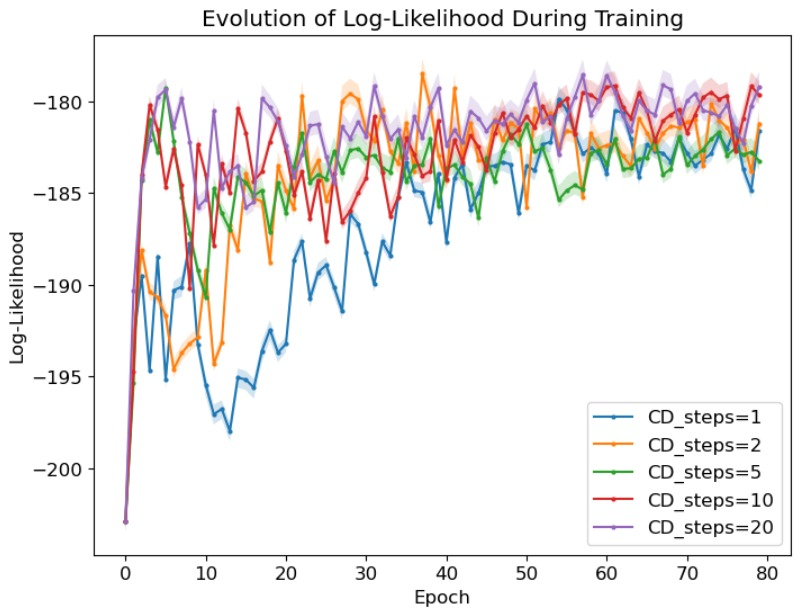
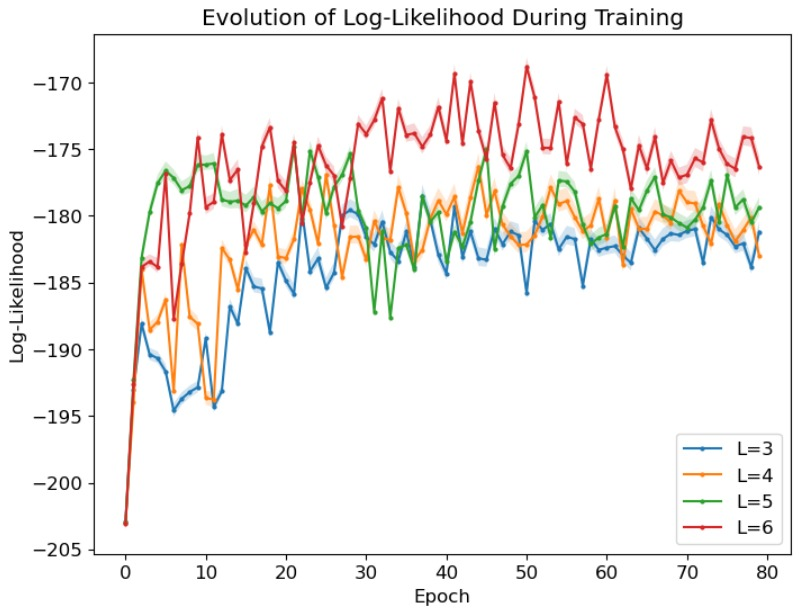

In [47]:
from IPython.display import display, HTML
import base64

def embed_image(image_path):
    with open(image_path, "rb") as f:
        encoded = base64.b64encode(f.read()).decode('utf-8')
    # Assuming the image is in JPEG format
    return f"data:image/jpeg;base64,{encoded}"

html = """
<div style="display: flex">
  <img src="{img}" alt="Image 1" width="35%" />
  <img src="{img1}" alt="Image 2" width="35%" />

</div>
""".format(img=embed_image("pietro.jpeg"),
           img1 =embed_image("pietro2.jpeg"))




display(HTML(html))


In [ ]:
from tabulate import tabulate

def test_hyperparameters(steps, Nepoch, Nmini, plot, info, L, learning_rates, gammas, grad_types, data):
    results = []
    for GRAD in grad_types:
        for gamma in gammas:
            for l_rate_ini, l_rate_fin in learning_rates:
                wE, aE, bE, gwE, gaE, gbE, miniE = RBM_train(steps=steps, Nepoch=Nepoch, Nmini=Nmini, plot=plot, info=info, L=L, GRAD=GRAD, gamma=gamma)
                log_likelihood = lkl(data, wE[-1], aE[-1], bE[-1], len(data), binary=True)
                results.append({
                    'gradient_type': GRAD,
                    'learning_rate': l_rate_ini,
                    'gamma': gamma,
                    'log_likelihood': log_likelihood
                })
    headers = ["Gradient Type", "LR Initial", "LR Final", "Gamma", "Log-Likelihood"]
    table_data = [[r['gradient_type'], r['learning_rate'], r['learning_rate'], r['gamma'], r['log_likelihood']] for r in results]
    print(tabulate(table_data, headers=headers, floatfmt=".6f"))
    return results

learning_rates = [(1.0, 0.25), (0.05, 0.05)]  
gammas = [0, 0.01, 0.1]
grad_types = ["SGD", "RMSprop"]
Nepoch = 100
test_hyperparameters(steps=5, Nepoch=100, Nmini=20, plot=False, info=False, L=3, learning_rates=learning_rates, gammas=gammas, grad_types=grad_types, data=data)


def train_and_log_likelihood(steps, Nepoch, Nmini, plot, info, L, GRAD, gamma, learning_rates, data):
    
    """Trains the RBM and computes log-likelihood at each epoch."""
    l_rate_ini, l_rate_fin = learning_rates
    log_likelihoods = []

    wE, aE, bE, gwE, gaE, gbE, miniE = RBM_train(steps, Nepoch, Nmini, plot, info, L, GRAD, gamma)
    
    for epoch in range(Nepoch + 1):    
        log_likelihood = lkl(data, wE[epoch], aE[epoch], bE[epoch], len(data), binary=True)
        log_likelihoods.append(log_likelihood)
    
    return log_likelihoods

def compute_log_likelihoods(steps, Nepoch, Nmini, plot, info, L, learning_rates, gammas, grad_types, data):
    """Computes and stores log-likelihood results for each parameter combination."""
    results = {}
    for GRAD in grad_types:
        for gamma in gammas:
            for l_rate_ini, l_rate_fin in learning_rates:
                if GRAD == "RMSprop" and (l_rate_ini, l_rate_fin) == (1.0, 0.25):
                    continue
                key = (GRAD, gamma, l_rate_ini, l_rate_fin)
                log_likelihoods = train_and_log_likelihood(steps, Nepoch, Nmini, plot, info, L, GRAD, gamma, (l_rate_ini, l_rate_fin), data)
                results[key] = log_likelihoods
    return results

import matplotlib.pyplot as plt

def plot_log_likelihood(results, Nepoch):
    """Plots the log-likelihood as a function of epochs for each gradient method in separate figures with correct colors."""
    
    grad_types = sorted(set(key[0] for key in results.keys()))

    for GRAD in grad_types:
        plt.figure(figsize=(7, 5))  
        
        colors = itertools.cycle(["b", "g", "r", "c", "m", "y", "k"])
        
        if GRAD == "SGD":
            labels = ["LR=1.0-0.25, γ=0.0", "LR=1.0-0.25, γ=0.1"]
        elif GRAD == "RMSprop":
            labels = ["LR=0.05-0.05, γ=0.0", "LR=0.05-0.05, γ=0.1"]
        else:
            labels = []
        
        lines = []  
        i = 0
        
        for key, log_likelihoods in results.items():
            if key[0] == GRAD:
                color = next(colors)  
                label = labels[i] if i < len(labels) else None  
                
                line, = plt.plot(range(Nepoch + 1), log_likelihoods, label=label, color=color)
                
                if label: 
                    lines.append(line)
                
                i += 1
        
        plt.title(f"Log-Likelihood ({GRAD})", fontsize=14)
        plt.xlabel("Epochs", fontsize=12)
        plt.ylabel("Log-Likelihood", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        
        if lines:  
            plt.legend(handles=lines, fontsize=10)

        plt.show() 

learning_rates = [(1.0, 0.25), (0.05, 0.05)]  
gammas = [0.0, 0.1]  
grad_types = ["SGD", "RMSprop"]  

results = compute_log_likelihoods(steps=2, Nepoch=100, Nmini=20, plot=False, info=False, L=3, learning_rates=learning_rates, gammas=gammas, grad_types=grad_types, data=data)
plot_log_likelihood(results, Nepoch)


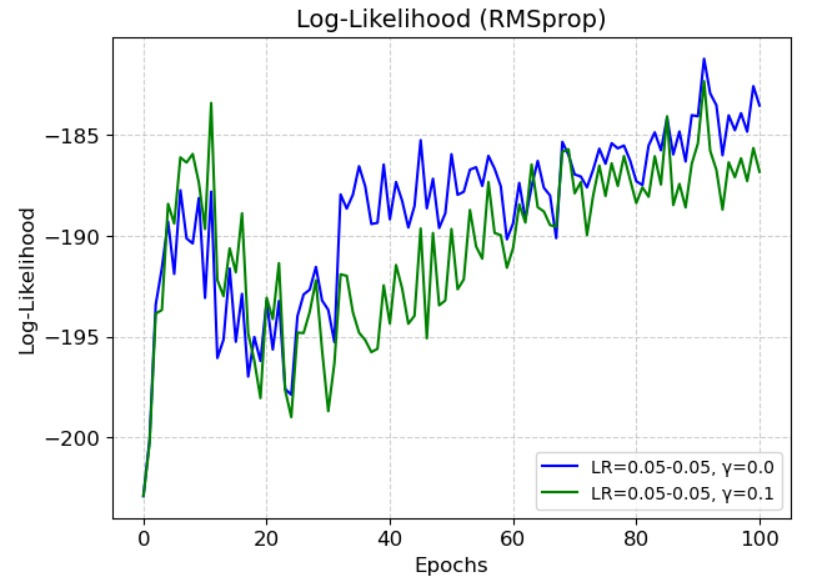
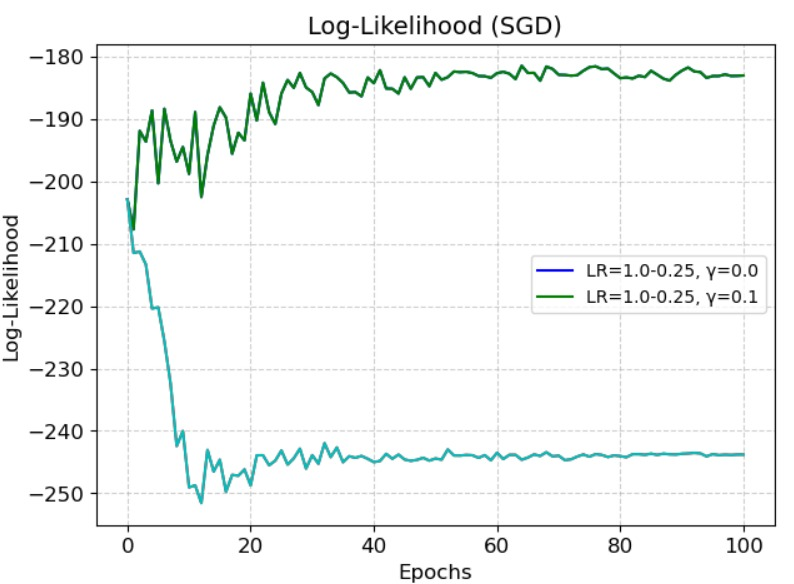

In [43]:
from IPython.display import display, HTML
import base64

def embed_image(image_path):
    with open(image_path, "rb") as f:
        encoded = base64.b64encode(f.read()).decode('utf-8')
    # Assumendo che le immagini siano in formato JPEG
    return f"data:image/jpeg;base64,{encoded}"

html = """
<div style="display: flex">
  <img src="{img1}" alt="Image 1" width="25%" />
  <img src="{img2}" alt="Image 2" width="25%" />
</div>
""".format(
    img1=embed_image("miguel1.jpeg"),
    img2=embed_image("miguel2.jpeg")
)

display(HTML(html))

### Log-Likelihood Results by Gradient Type and Hyperparameters

| Gradient Type | LR Initial | LR Final | Gamma   | Log-Likelihood     |
|---------------|------------|----------|---------|--------------------|
| SGD           | 1.000000   | 1.000000 | 0.000000 | -183.034958        |
| SGD           | 0.050000   | 0.050000 | 0.000000 | -183.034958        |
| SGD           | 1.000000   | 1.000000 | 0.010000 | -187.064281        |
| SGD           | 0.050000   | 0.050000 | 0.010000 | -187.064281        |
| SGD           | 1.000000   | 1.000000 | 0.100000 | -245.770008        |
| SGD           | 0.050000   | 0.050000 | 0.100000 | -245.770008        |
| RMSprop       | 1.000000   | 1.000000 | 0.000000 | -183.335079        |
| RMSprop       | 0.050000   | 0.050000 | 0.000000 | -183.335079        |
| RMSprop       | 1.000000   | 1.000000 | 0.010000 | -183.405108        |
| RMSprop       | 0.050000   | 0.050000 | 0.010000 | -183.405108        |
| RMSprop       | 1.000000   | 1.000000 | 0.100000 | -184.340427        |
| RMSprop       | 0.050000   | 0.050000 | 0.100000 | -184.340427        |





The obtained results indicate that when using SGD, a higher gamma value (0.1) leads to a much worse log-likelihood (-245.77), suggesting instability in the training process. Lower gamma values (0 and 0.01) provide better performance.
For RMSprop, the performance is more stable across different configurations, with log-likelihood values remaining around -183.3 to -184.3. However, increasing gamma also negatively affects the log-likelihood, though not as drastically as in SGD.
The best configuration appears to be SGD with γ = 0 and any learning rate, achieving a log-likelihood of -183.03, which is slightly better than the best RMSprop configurations. 

For the two subplots:
For the RMSprop results, both configurations exhibit very similar training curves, suggesting that the overall learning dynamics remain comparable. However, the final log-likelihood differs, indicating that the choice of gamma influences the long-term convergence. A higher gamma (0.1) results in a slightly worse final log-likelihood.
For the SGD results, the impact of gamma is much more pronounced. With γ = 0.0, the log-likelihood stabilizes at a better final value, confirming that standard SGD without momentum performs well. However, with γ = 0.1, the log-likelihood significantly worsens, reinforcing the idea that an excessive momentum term destabilizes training, leading to poor convergence. 


In [ ]:
with open("intermediate_calculations2.txt", "w") as file:
    pass  
file = open("intermediate_calculations2.txt",'a') 
steps=[2,4,6]
lkl_list=[]
Nepoch = 100

for step in steps:
    Nt = step
    line = f'\n\nnew step: {step}\n'
    file.write(line)
    log_likelihood_values = np.zeros(Nepoch+1)
    wE, aE, bE, gwE, gaE, gbE,  gwE_d, gaE_d, gbE_d, miniE, str_time_completion= RBM_train(step, Nepoch= Nepoch, Nmini=20, plot=False)
    for epoch in range(1, Nepoch + 1):  
        #print(f'epoch: {epoch}')
        line = f'\n\nnew epoch: {epoch}\n'
        file.write(line)
        log_likelihood_values[epoch] = compute_log_likelihood_spin(data, wE[epoch], aE[epoch], bE[epoch], SPINS) #############################################################################################################################
        #print(log_likelihood_values[epoch])
    lkl_list.append(log_likelihood_values[1:])


# just training prints

In [ ]:
plot_lkl=True
if plot_lkl:
    fig, ax = plt.subplots(1,1,figsize=(8, 6))
    for i,step in enumerate(steps):
        ax.plot(np.arange(1,Nepoch+1), lkl_list[i], marker='o', markersize=2, linestyle='-', label=f'CDstep:{step}')
    ax.legend()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Log-Likelihood')
    ax.set_title('Evolution of Log-Likelihood During Training')

# this ones are compared at the end
    

## Test generative power of the trained RBM

<Figure size 640x480 with 0 Axes>

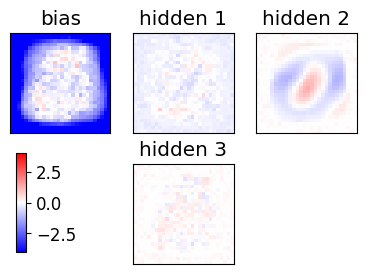

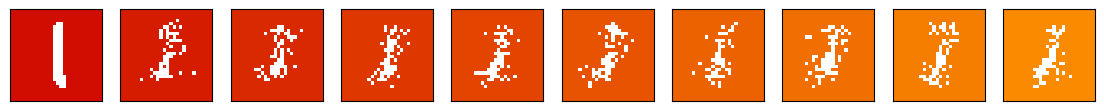

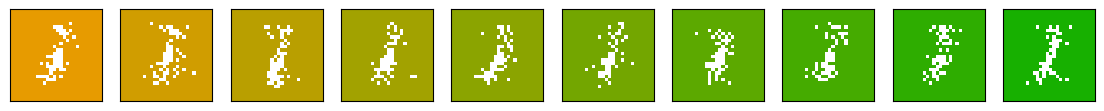

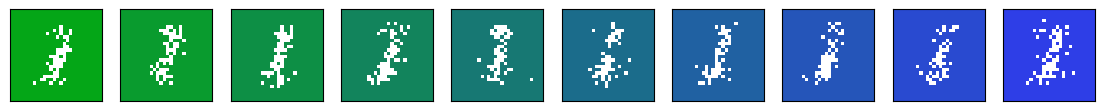

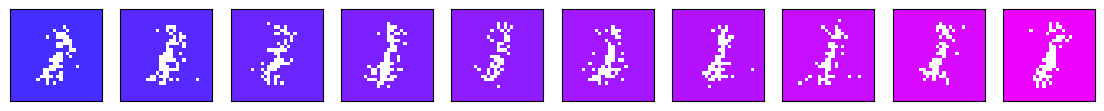

L: 3     amplification of weights: 2.0


In [14]:
ee=-1
NN=200
traj_x,traj_z = np.zeros((NN+2,D)), np.zeros((NN+2,L))
xf=np.copy(data[np.random.randint(Nd)])
traj_x[0]=np.copy(xf)

# AF: multiply weights and biases by a number >1 to achieve a more deterministic behavior,
# equivalent to lower the temperature in a Boltzmann weight -> select lowest energies
# Note: here, this is done in the negative CD step only
AF=2.

for t in range(NN):
    t1=t+1
    # positive CD phase: generating fantasy zf from fantasy xf 
    zf = CD_step(xf,1*wE[ee],1*bE[ee],POTTS=POTTS)
    traj_z[t] = np.copy(zf)
    # negative CD pzase: generating fantasy xf from fantasy zf
    xf = CD_step(zf,AF*wE[ee].T,AF*aE[ee])
    traj_x[t1] = np.copy(xf)

Ncols=min(8,max(2,L//2))
plot_weights_bias(wE, aE, Nepoch, L, cols=Ncols, save=False)

col0,col1,col2,col3,col4=(0.8,0,0,1),(1,0.6,0,1),(0,.7,0,1),(0.2,0.2,1,1),(1,0,1,1)
show_MNIST(traj_x[0:],Nex=10,colors=(col0,col1))
show_MNIST(traj_x[10:],Nex=10,colors=(col1,col2))
show_MNIST(traj_x[20:],Nex=10,colors=(col2,col3))
show_MNIST(traj_x[40:],Nex=10,colors=(col3,col4))
print("L:",L,"    amplification of weights:",AF)

## Plot of the gradient amplitude

In [ ]:
## more accurate later
def make_fname(strin):
    fname="FIG/RBM_"+strin+"_MNIST"+str(Ndigit)+"_E"+str(NE)+"_N"+str(N_ini)+"-"+str(N_fin)
    fname=fname+"_"+GRAD+"-"+str(l_rate_ini)+"-"+str(l_rate_fin)+"_CD-"+str(Nt)+"_L"+str(L)
    if gamma>0:  fname=fname+"_reg"+str(gamma)
    return fname+".png"

NE = len(gwE)-1
print("NE=",NE)
mgw,mga,mgb,epo=np.zeros(NE),np.zeros(NE),np.zeros(NE),np.zeros(NE)
DE=1
if NE>30: DE=2
if NE>50: DE=5
if NE>100: DE=10
# compute RMS average of gradients during epochs
for ep in range(1,1+NE):
    epo[ep-1]=ep
    mgw[ep-1] = np.std(gwE[ep])
    mga[ep-1] = np.std(gaE[ep])
    mgb[ep-1] = np.std(gbE[ep])

#############################################################################
# creating grid for subplots
fig, ax = plt.subplots(1, 1, figsize=(8,5.5))
fig.subplots_adjust( left=None, bottom=None,  right=None, top=None, wspace=None, hspace=None)
        
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(DE))
ax.plot(epo,mgw,"o-",c="#CC77EC",label="$w$",zorder=10)
ax.plot(epo,mga,"d--",c="#22C040",label="$a$",zorder=5)
ax.plot(epo,mgb,"^:",c="#EEC006",label="$b$",zorder=8)
ax.plot(epo,.35/sqrt(miniE[1:]),"k-.",label="$\sim 1 / \sqrt{N}$",zorder=20,lw=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("gradient RMS")
ax.set_xlim(0.5,NE+0.5)
if 1==2: ax.set_ylim(0,)
else: 
    ax.set_xlim(0.8,Nepoch*1.1)
    ax.set_xscale("log")
    ax.set_yscale("log")
ax.legend()

fname=make_fname("grad")
fig.savefig(fname,dpi=200,bbox_inches='tight',pad_inches=0.02, transparent=False)
plt.show()
print(fname)



### SPINS Log-Likelihood Adjustment

In order to perform the SPINS calculation of the log-likelihood, an adjustment needed to be made.  
In the Bernoulli formula, we end up with a product of terms of the form:

$$
1 + \exp(Hx)
$$

However, since now  x, z = {-1, 1\} , this expression becomes:

$$
1 + \exp(Hx) => 2 \cosh(Hx)
$$




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy as np

def compute_log_likelihood_bernoulli(data, w, a, b):

    N, D = data.shape
    L = b.size

    all_z = []
    for val in range(2**L):
        z_vec = [(1 if (val & (1 << bit)) else 0) for bit in range(L)]
        all_z.append(z_vec)
    all_z = np.array(all_z, dtype=np.float64) 

    logZ_terms = []
    for z in all_z:
        H_val = a + w @ z        
        log_factor = np.sum(np.log(1 + np.exp(H_val))) 
        logZ_terms.append(np.dot(b, z) + log_factor)
    
    max_logZ = np.max(logZ_terms)
    sum_exp = np.sum(np.exp(np.array(logZ_terms) - max_logZ))
    logZ = max_logZ + np.log(sum_exp)

    log_likelihood = 0.0
    for x in data:
        log_terms_x = []
        for z in all_z:
            log_terms_x.append(np.dot(b, z) + np.dot(x, w @ z))
        
        max_ltx = np.max(log_terms_x)
        sum_exp_x = np.sum(np.exp(np.array(log_terms_x) - max_ltx))
        log_sum_xz = max_ltx + np.log(sum_exp_x)
        log_likelihood += (np.dot(x, a) + log_sum_xz - logZ)
    
    return log_likelihood / N

def compute_log_likelihood_spin(data, w, a, b, SPINS):
    """
    Calcola la log-likelihood media di una RBM di tipo spin
    x_i, z_mu in {-1, +1}.
    """
    N, D = data.shape
    L = b.size
    all_z = []
    for val in range(2**L):
        z_vec = [(+1 if (val & (1 << bit)) else -1) for bit in range(L)]
        all_z.append(z_vec)
    all_z = np.array(all_z, dtype=np.float64)  # shape = (2^L, L)
    
    logZ_terms = []
    for z in all_z:
        G_val = np.exp(np.dot(b, z))
        H_val = a + w @ z   
        log_factor = D * np.log(2.0) + np.sum(np.log(np.cosh(H_val)))
        logZ_terms.append(np.log(G_val) + log_factor)
    
    max_logZ = np.max(logZ_terms)
    sum_exp = np.sum(np.exp(np.array(logZ_terms) - max_logZ))
    logZ = max_logZ + np.log(sum_exp)
    
    log_likelihood = 0.0
    for x in data:
        log_terms_x = []
        for z in all_z:
            G_val = np.dot(b, z) 
            H_val = a + w @ z 
            dot_xH = np.dot(x, H_val)
            log_terms_x.append(G_val + dot_xH)
        
        max_ltx = np.max(log_terms_x)
        sum_exp_x = np.sum(np.exp(np.array(log_terms_x) - max_ltx))
        log_sum_xz = max_ltx + np.log(sum_exp_x)
        log_likelihood += (log_sum_xz - logZ)
    
    return log_likelihood / N

steps = [2, 4, 6]         
Nepoch = 100         

lkl_list = []
grad_w_list = []
grad_a_list = []

with open("intermediate_calculations2.txt", "w") as file:
    file.write("Log delle simulazioni per differenti CD steps\n")

for step in steps:
    Nt = step

    wE, aE, bE, gwE, gaE, gbE, gwE_d, gaE_d, gbE_d, miniE, str_time_completion = RBM_train(step, Nepoch=Nepoch, Nmini=20, plot=False)
    
    log_likelihood_values = np.zeros(Nepoch+1)
    for epoch in range(1, Nepoch + 1):  
        log_likelihood_values[epoch] = compute_log_likelihood_spin(data, wE[epoch], aE[epoch], bE[epoch], SPINS)
        #print(f"CD {step} - epoca {epoch}: log-likelihood = {log_likelihood_values[epoch]}")
    
    lkl_list.append(log_likelihood_values[1:])
    
    NE = len(gwE) - 1  
    mgw = np.zeros(NE)
    mga = np.zeros(NE)
    for ep in range(1, NE + 1):
        mgw[ep-1] = np.std(gwE[ep])
        mga[ep-1] = np.std(gaE[ep])
    
    grad_w_list.append(mgw)
    grad_a_list.append(mga)
    
    with open("intermediate_calculations2.txt", "a") as file:
        file.write(f"\n\nCD steps: {step}\n")
        for epoch in range(1, Nepoch + 1):
            file.write(f"Epoca {epoch}: Log-likelihood = {log_likelihood_values[epoch]}\n")

plt.figure(figsize=(8,6))
for idx, step in enumerate(steps):
    plt.plot(np.arange(1, Nepoch+1), lkl_list[idx], marker='o', label=f'CD steps = {step}')
plt.xlabel("Epoch")
plt.ylabel("Log-likelihood")
plt.title(f"Log-likelihood - {GRAD}")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for idx, step in enumerate(steps):
    epochs = np.arange(1, len(grad_w_list[idx])+1)
    plt.plot(epochs, grad_w_list[idx], marker='s', label=f'CD steps = {step}')
plt.xlabel("Epoch")
plt.ylabel("RMS (w)")
plt.title(f"RMS (w) - {GRAD}")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for idx, step in enumerate(steps):
    epochs = np.arange(1, len(grad_a_list[idx])+1)
    plt.plot(epochs, grad_a_list[idx], marker='^', label=f'CD steps = {step}')
plt.xlabel("Epoch")
plt.ylabel("RMS (a)")
plt.title(f"RMS (a) - {GRAD}")
plt.legend()
plt.grid(True)
plt.show()


# ORDERED OUTPUT LATER

## Save weights over epochs on file

In [ ]:
def make_weights_fname(label,dname="WEIGHTS"):
    fname=dname+"/"+label+"_"+str_simul+"_MNIST"+str(Ndigit)+"_L"+str(L)
    fname=fname+"_"+GRAD+"-"+"{:.2f}".format(l_rate_ini)+"-"+"{:.2f}".format(l_rate_fin)+"_Ep"+str(Nepoch)
    if gamma>0:  fname=fname+"_reg"+"{:.3g}".format(gamma)
    if POTTS: fname+="_POTTS"
    if SPINS: fname+="_SPINS"
    fname=fname+str_time_completion
    return fname+".npy"

def save_epochs(qE,label):
    fname=make_weights_fname(label)
    print(fname)
    np.save(fname,qE)

save_epochs(wE,"w")
save_epochs(bE,"b")
save_epochs(aE,"a")

Nd

WEIGHTS/w_RBM_MNIST3_L3_SGD-1.00-0.25_Ep100_reg0.001_SPINS_20250322_1541.npy
WEIGHTS/b_RBM_MNIST3_L3_SGD-1.00-0.25_Ep100_reg0.001_SPINS_20250322_1541.npy
WEIGHTS/a_RBM_MNIST3_L3_SGD-1.00-0.25_Ep100_reg0.001_SPINS_20250322_1541.npy


### Below we compare the SPINS vs BERNOULLI case for 3 different values of CD steps and for 2 Gradient algorythms

SPINS,BERNOULLI
,
,
,

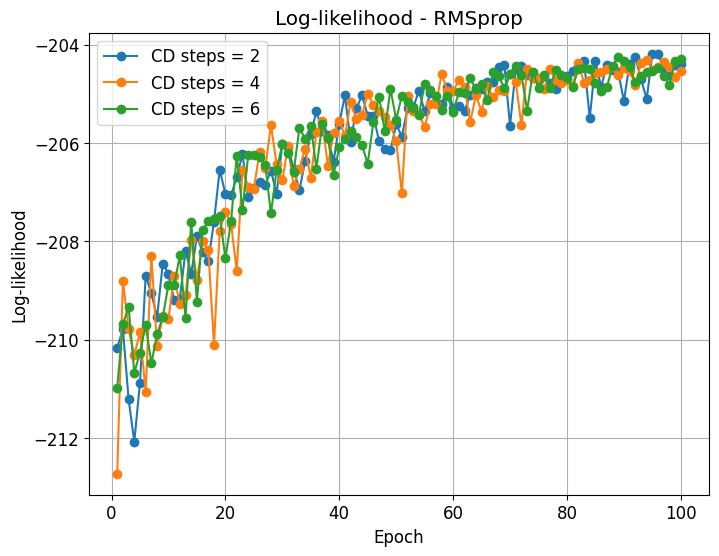
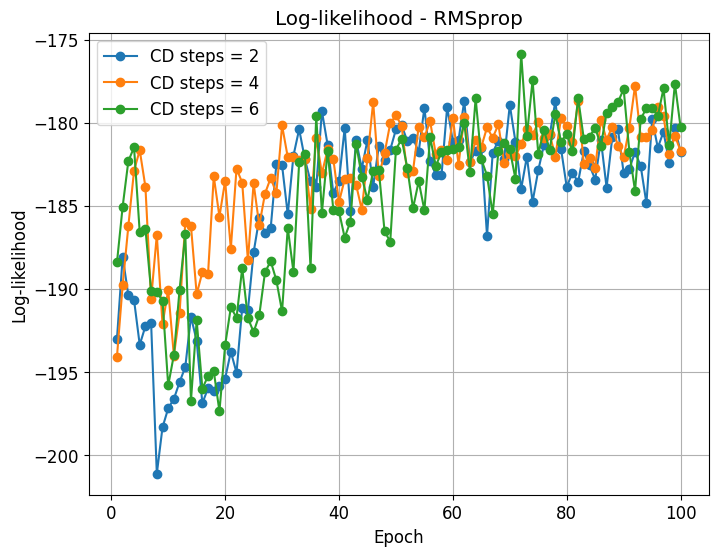
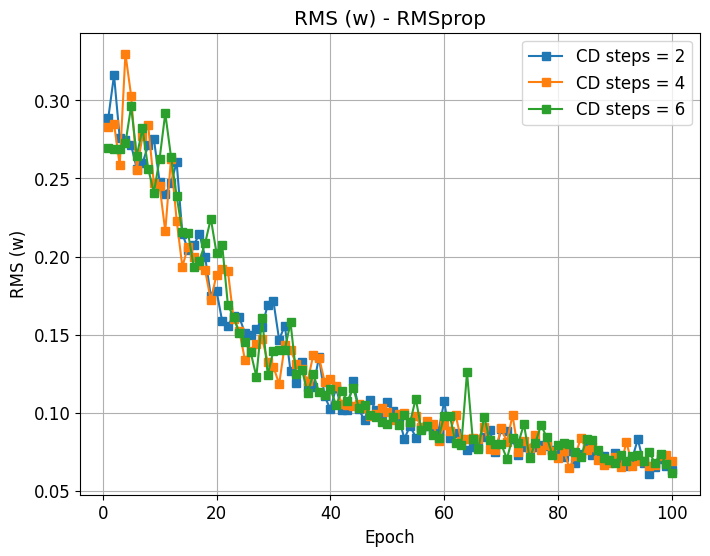
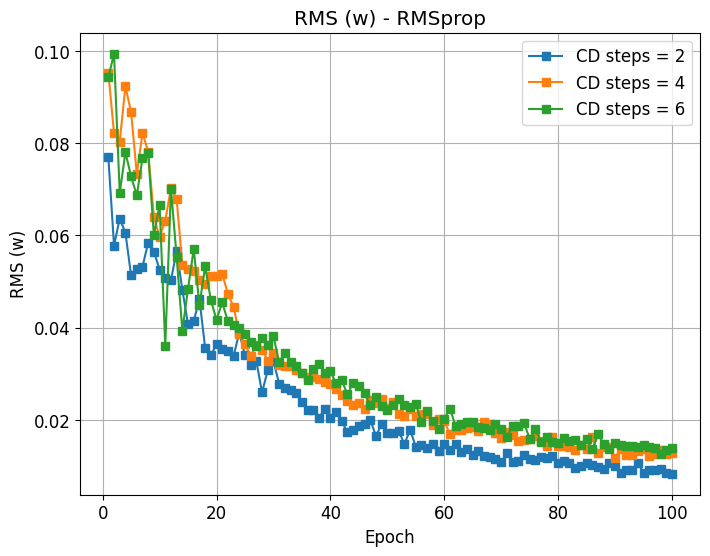
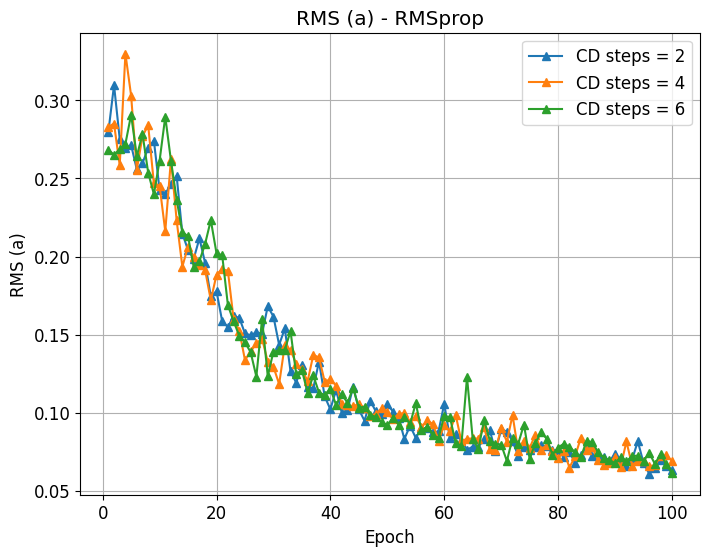
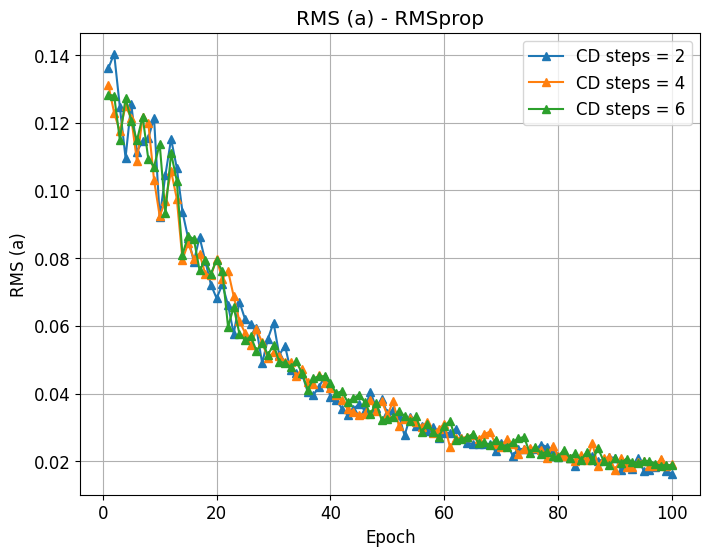

In [39]:
from IPython.display import HTML, display
import base64

def embed_image(image_path, width=600):
    with open(image_path, "rb") as f:
        encoded = base64.b64encode(f.read()).decode('utf-8')
    return f'<img src="data:image/png;base64,{encoded}" style="width:{width}px;">'

# Build an HTML table with embedded images and escaped curly braces for the style block
html = """
<style>
  th {{
    font-size: 40px;
    padding: 12px;
  }}
</style>
<table>
  <tr>
    <th>SPINS</th>
    <th>BERNOULLI</th>
  </tr>
  <tr>
    <td>{img1}</td>
    <td>{img4}</td>
  </tr>
  <tr>
    <td>{img2}</td>
    <td>{img5}</td>
  </tr>
  <tr>
    <td>{img3}</td>
    <td>{img6}</td>
  </tr>
</table>
""".format(
    img1=embed_image("plot RBM/1.png"),
    img2=embed_image("plot RBM/2.png"),
    img3=embed_image("plot RBM/3.png"),
    img4=embed_image("plot RBM/4.png"),
    img5=embed_image("plot RBM/5.png"),
    img6=embed_image("plot RBM/6.png"),
)

display(HTML(html))



SPINS,BERNOULLI
,
,
,

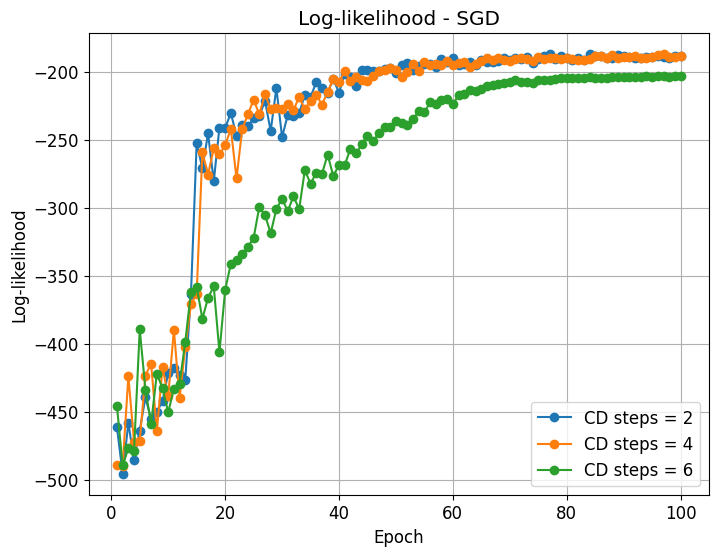
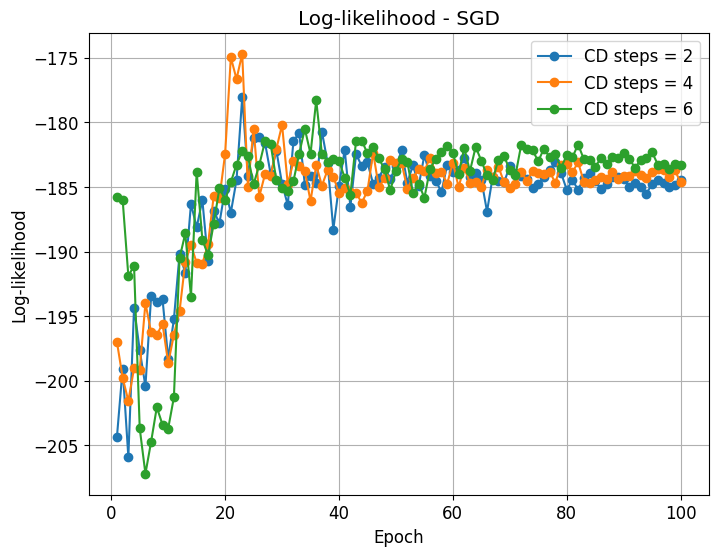
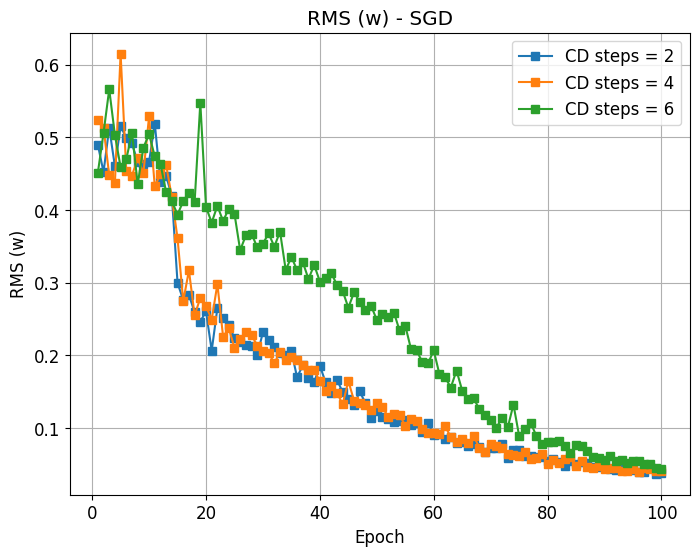
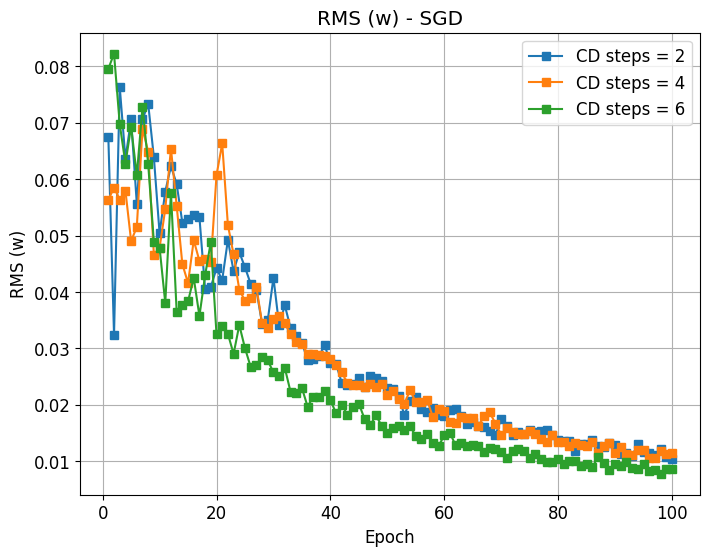
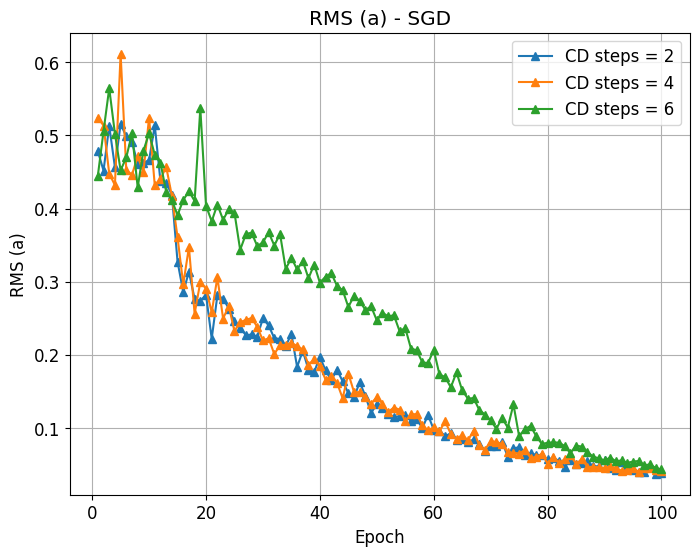
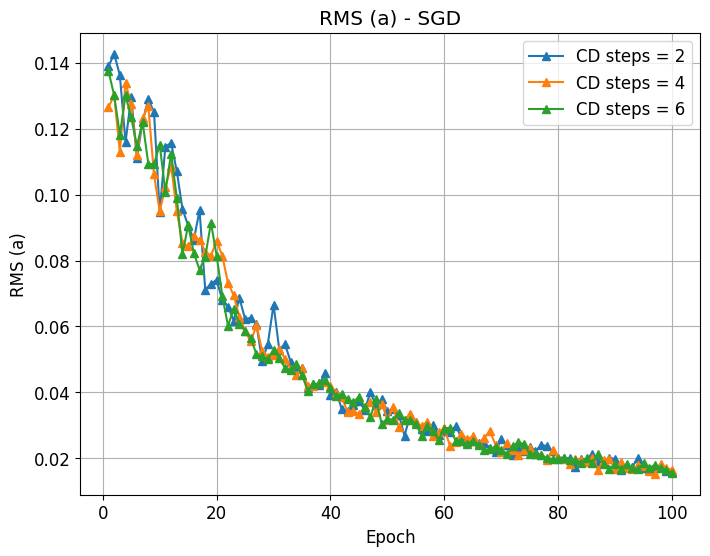

In [42]:
from IPython.display import HTML, display
import base64

def embed_image(image_path, width=600):
    with open(image_path, "rb") as f:
        encoded = base64.b64encode(f.read()).decode('utf-8')
    return f'<img src="data:image/png;base64,{encoded}" style="width:{width}px;">'

# Build an HTML table with embedded images and escaped curly braces for the style block
html = """
<style>
  th {{
    font-size: 40px;
    padding: 12px;
  }}
</style>
<table>
  <tr>
    <th>SPINS</th>
    <th>BERNOULLI</th>
  </tr>
  <tr>
    <td>{img1}</td>
    <td>{img4}</td>
  </tr>
  <tr>
    <td>{img2}</td>
    <td>{img5}</td>
  </tr>
  <tr>
    <td>{img3}</td>
    <td>{img6}</td>
  </tr>
</table>
""".format(
    img1=embed_image("plot RBM/1s.png"),
    img2=embed_image("plot RBM/2s.png"),
    img3=embed_image("plot RBM/3s.png"),
    img4=embed_image("plot RBM/4s.png"),
    img5=embed_image("plot RBM/5s.png"),
    img6=embed_image("plot RBM/6s.png"),
)

display(HTML(html))



## We can see that the Bernoulli approach gives overall better results than SPINS in every case
## RMSprop gives a more "linear" learning as expected however it worked better than RMSprop for the SPINS case
## With more CD steps we see a less "bumpy" learning, espetially in the SGD gradient

## Overall the training was done with a limited amount of epochs (100), from the graphs we can see that with RMSprop there was still some learning to be made